# Задание
Поддерживать и стимулировать пользовательскую активность – важная задача для продукта, подобного нашему. Для этого наша команда маркетологов решила организовать флэшмоб в ленте новостей: участники должны сделать пост, где они рассказывают какой-то интересный факт о себе, и опубликовать его с хэштегом. Три поста, собравших наибольшее число лайков, получают призы.

Флэшмоб проходил с 2023-08-13 по 2023-08-19. Ваша задача как аналитика – оценить эффективность этого мероприятия.

Предположите, какие метрики должны были измениться во время флэшмоба и как. Почему?
Проверьте, реально ли эти метрики изменились, используя CausalImpact. Если изменение действительно произошло - опишите, как именно изменилась метрика и насколько.
Имел ли флэшмоб какие-то долгосрочные эффекты? Сделайте выводы.

# Подготовка данных

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import pandahouse as ph
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt
import seaborn as sns

import causalimpact
from causalimpact import CausalImpact


2023-09-12 19:51:35.181961: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-12 19:51:35.252662: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-12 19:51:35.253724: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 19:51:36.336764: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [66]:
# настраиваем размер графиков
sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")

In [3]:
# подключаемся к ClickHouse и считываем необходимые данные
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230820',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

q = '''
SELECT
    user_id,
    post_id,
    action,
    time
FROM 
    {db}.feed_actions 
WHERE 
    toDate(time) <= '2023-08-19'
'''

total_df = ph.read_clickhouse(q, connection=connection)

In [4]:
# смотрим заголовок датафрейма
total_df.head()

,user_id,post_id,action,time
0,148500,3137,view,2023-08-14 20:43:41
1,4578,3118,view,2023-08-14 20:43:42
2,12459,3181,view,2023-08-14 20:43:42
3,30196,2989,view,2023-08-14 20:43:42
4,36941,3129,view,2023-08-14 20:43:42


In [5]:
# добавляем преобразованный формат дат
total_df["day_time"] = pd.to_datetime(total_df.time).dt.date.astype("datetime64[ns]")

In [6]:
# оставляем в датафрейме необходимые данные
total_df = total_df[["day_time", "user_id", "post_id", "action"]]

In [7]:
total_df.head()

,day_time,user_id,post_id,action
0,2023-08-14,148500,3137,view
1,2023-08-14,4578,3118,view
2,2023-08-14,12459,3181,view
3,2023-08-14,30196,2989,view
4,2023-08-14,36941,3129,view


# Метрики которые должны были измениться
Так как флэшмоб был направлен на повышение пользовательской активности во время его проведения оценить эффект можно по изменению следующих метрик: DAU, количество лайков, количество просмотров, CTR, уникальные просматриваемые посты, новые посты. Проверим реально ли эти метрики изменились, используя CausalImpact.


## DAU

In [8]:
# выгружаем данные
query_dau = '''
SELECT 
    toStartOfDay(time) day_time,
    uniqExact(user_id) DAU
FROM 
    {db}.feed_actions
WHERE 
    toDate(time) <= '2023-08-19'
GROUP BY day_time
ORDER BY 
    day_time
'''

dau = ph.read_clickhouse(query = query_dau, connection = connection)

In [9]:
dau.head()

,day_time,DAU
0,2023-07-03,878
1,2023-07-04,2238
2,2023-07-05,3105
3,2023-07-06,3721
4,2023-07-07,4617


<Axes: xlabel='day_time', ylabel='DAU'>

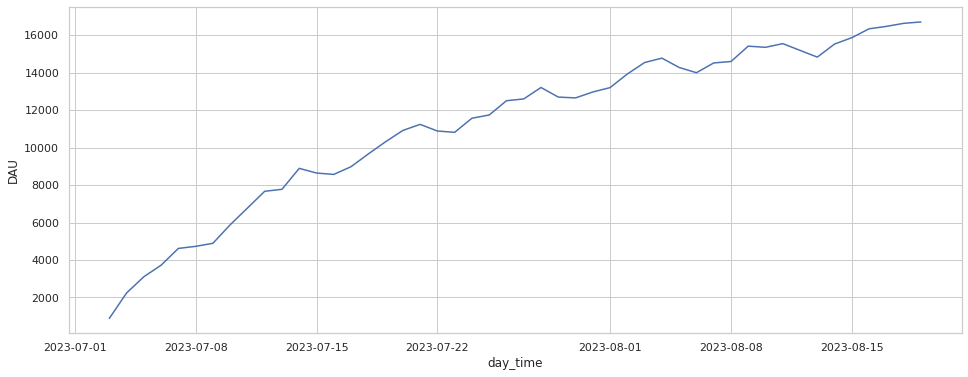

In [67]:
sns.lineplot(data=dau, x="day_time", y="DAU")

In [11]:
# строим модель
dau_ci = CausalImpact(data=dau.set_index("day_time"), 
             pre_period=[pd.Timestamp("2023-07-03"), 
                         pd.Timestamp("2023-08-12")],
             post_period=[pd.Timestamp("2023-08-13"), 
                         pd.Timestamp("2023-08-19")])

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2023-09-12 19:52:36.239053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-09-12 19:52:36.239204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-09-12 19:52:36.250391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-09-12 19:52:36.250543: I tens

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`


2023-09-12 19:52:37.362073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-12 19:52:37.386500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_1_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-12 19:52:37.430935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node monte_carlo_variational_loss/expectation/powerInv

Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


2023-09-12 19:52:55.115909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-09-12 19:52:55.234204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

In [12]:
# выводим summary по модели
print(dau_ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    16052.71           112369.0
Prediction (s.d.)         14970.03 (1097.88) 104790.22 (7685.14)
95% CI                    [12856.33, 17159.93][89994.3, 120119.51]

Absolute effect (s.d.)    1082.68 (1097.88)  7578.78 (7685.14)
95% CI                    [-1107.22, 3196.39][-7750.51, 22374.7]

Relative effect (s.d.)    7.23% (7.33%)      7.23% (7.33%)
95% CI                    [-7.4%, 21.35%]    [-7.4%, 21.35%]

Posterior tail-area probability p: 0.17
Posterior prob. of a causal effect: 82.92%

For more details run the command: print(impact.summary('report'))


Вероятность того, что казульный эффект произошел небольшая, доверительные интервалы пересекают ноль, модель скорее говорит о том, что DAU в результате нашего флэшмоба не вырос.

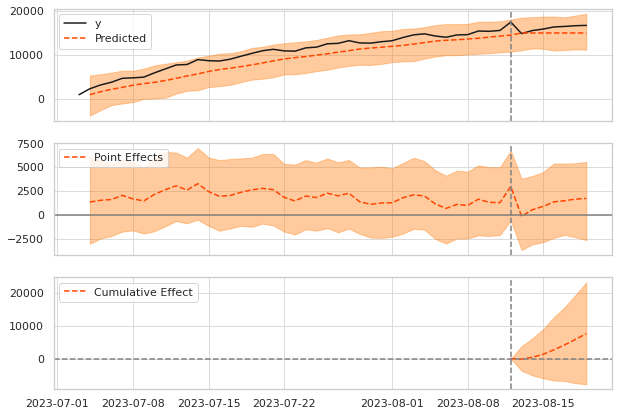

In [13]:
# рисуем график
dau_ci.plot()

На графике так же можно увидеть, что реальные значения DAU находятся в предсказанном моделью интервале.

## Лайки, просмотры

In [14]:
# выгружаем данные
query_act = '''
SELECT 
    toStartOfDay(time) day_time,
    countIf(action = 'view') views,
    countIf(action = 'like') likes,
    likes/views CTR
FROM 
    {db}.feed_actions 
WHERE 
    toDate(time) <= '2023-08-19'
GROUP BY day_time
ORDER BY 
    day_time
'''

activity = ph.read_clickhouse(query = query_act, connection = connection)

In [15]:
activity.head()

,day_time,views,likes,CTR
0,2023-07-03,7603,1560,0.205182
1,2023-07-04,62770,12816,0.204174
2,2023-07-05,105526,20958,0.198605
3,2023-07-06,118996,23800,0.200007
4,2023-07-07,174454,34504,0.197783


<Axes: xlabel='day_time', ylabel='views'>

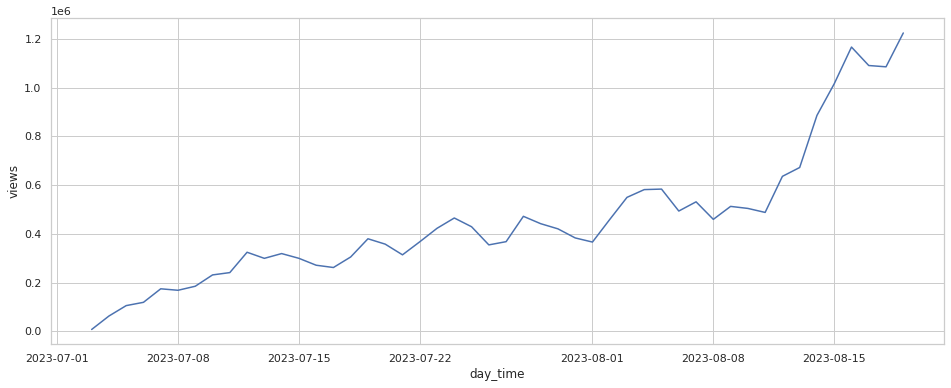

In [68]:
# строим график по просмотрам
sns.lineplot(data=activity, x="day_time", y="views")

<Axes: xlabel='day_time', ylabel='likes'>

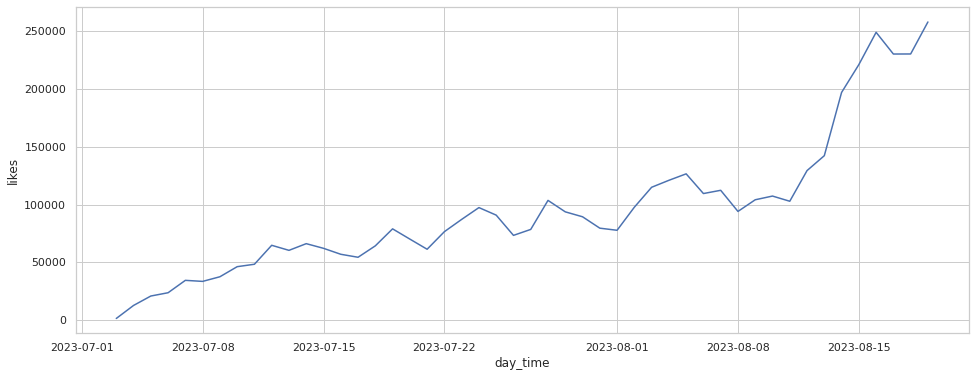

In [69]:
# строим график по лайкам
sns.lineplot(data=activity, x="day_time", y="likes")

In [18]:
# строим модель по просмотрам
views_ci = CausalImpact(data=activity.set_index('day_time').views, 
             pre_period=[pd.Timestamp("2023-07-03"), 
                         pd.Timestamp("2023-08-12")],
             post_period=[pd.Timestamp("2023-08-13"), 
                         pd.Timestamp("2023-08-19")])

2023-09-12 19:52:59.796399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-12 19:52:59.824075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-09-12 19:53:00.547831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-12 19:

In [19]:
# выводим summary по модели просмотров
print(views_ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1019947.31         7139631.0
Prediction (s.d.)         364460.44 (48349.27)2551223.0 (338444.87)
95% CI                    [265310.78, 454836.46][1857175.49, 3183855.27]

Absolute effect (s.d.)    655486.88 (48349.27)4588408.0 (338444.87)
95% CI                    [565110.85, 754636.54][3955775.73, 5282455.51]

Relative effect (s.d.)    179.85% (13.27%)   179.85% (13.27%)
95% CI                    [155.05%, 207.06%] [155.05%, 207.06%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


Реальные значения просмотров ощутимо выше, чем предсказанные, относительный прирост примерно 180%. Казуальный эффект есть.

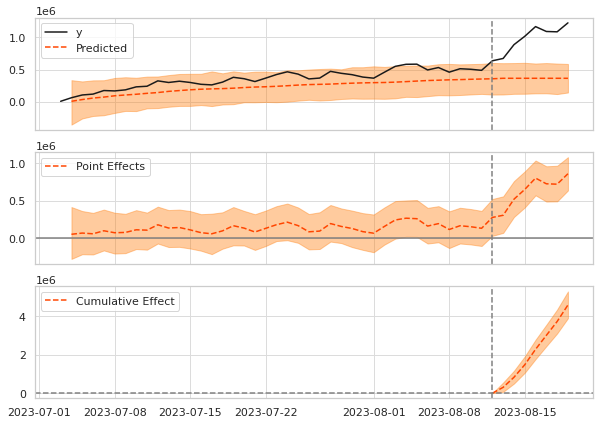

In [20]:
# рисуем график
views_ci.plot()

In [21]:
# строим модель по лайкам
likes_ci = CausalImpact(data=activity.set_index('day_time').likes, 
             pre_period=[pd.Timestamp("2023-07-03"), 
                         pd.Timestamp("2023-08-12")],
             post_period=[pd.Timestamp("2023-08-13"), 
                         pd.Timestamp("2023-08-19")])

2023-09-12 19:53:22.552226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-12 19:53:22.577529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-09-12 19:53:23.190428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-12 19:

2023-09-12 19:53:41.634226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-09-12 19:53:41.739210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

In [22]:
# выводим summary по модели лайков
print(likes_ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    218090.14          1526631.0
Prediction (s.d.)         75755.24 (9853.7)  530286.69 (68975.9)
95% CI                    [56307.3, 94933.11][394151.15, 664531.77]

Absolute effect (s.d.)    142334.91 (9853.7) 996344.31 (68975.9)
95% CI                    [123157.03, 161782.84][862099.23, 1132479.85]

Relative effect (s.d.)    187.89% (13.01%)   187.89% (13.01%)
95% CI                    [162.57%, 213.56%] [162.57%, 213.56%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


По лайкам реальные значения так же ощутимо выще предсказанных моделью, относительный прирост примерно 186%. Казуальный эффект есть

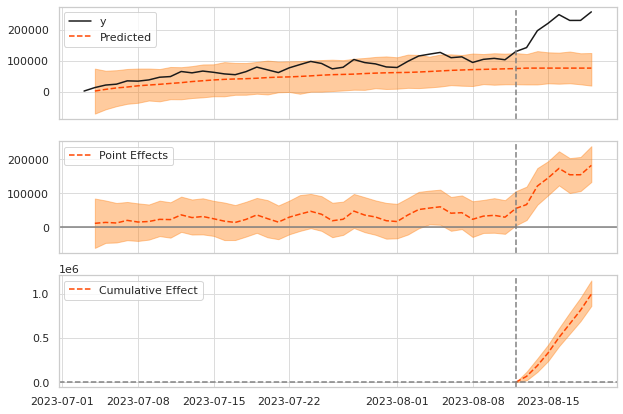

In [23]:
# рисуем график
likes_ci.plot()

## СTR

<Axes: xlabel='day_time', ylabel='CTR'>

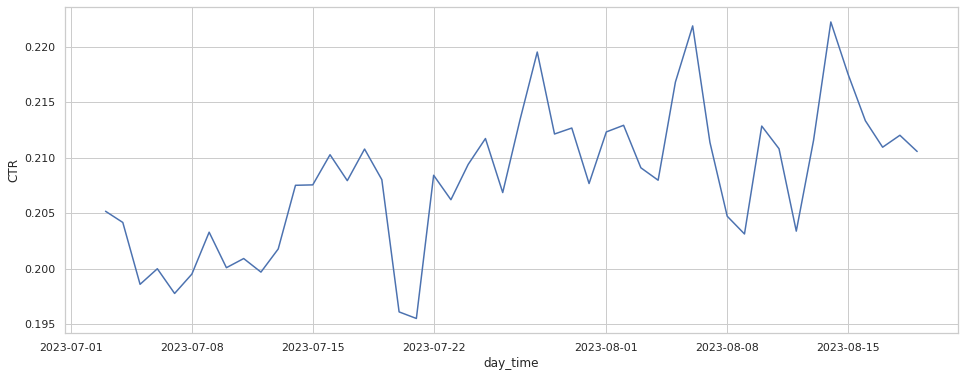

In [70]:
sns.lineplot(data=activity, x="day_time", y="CTR")

In [25]:
# строим модель по CTR
ctr_ci = CausalImpact(data=activity.set_index('day_time').CTR, 
             pre_period=[pd.Timestamp("2023-07-03"), 
                         pd.Timestamp("2023-08-12")],
             post_period=[pd.Timestamp("2023-08-13"), 
                         pd.Timestamp("2023-08-19")])

2023-09-12 19:53:45.389847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-12 19:53:45.416922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-09-12 19:53:45.946308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-12 19:

In [26]:
# выводим summary по CTR
print(ctr_ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.21               1.5
Prediction (s.d.)         0.21 (0.0)         1.45 (0.01)
95% CI                    [0.2, 0.21]        [1.42, 1.48]

Absolute effect (s.d.)    0.01 (0.0)         0.05 (0.01)
95% CI                    [0.0, 0.01]        [0.02, 0.08]

Relative effect (s.d.)    3.3% (0.97%)       3.3% (0.97%)
95% CI                    [1.48%, 5.29%]     [1.48%, 5.29%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.9%

For more details run the command: print(impact.summary('report'))


Модель показывает, что лайки выросли хоть и не сильно, но статистически значимо. Относительный эффект 3,3%.

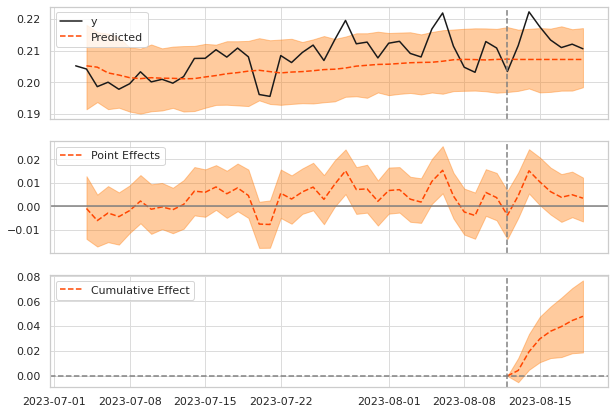

In [27]:
# рисуем график
ctr_ci.plot()

## Уникальные просматриваемые посты

In [28]:
# выгружаем данные
query_post_uniq = '''
SELECT 
    toStartOfDay(time) day_time,
    uniqExact(post_id) viewed_posts
FROM 
    {db}.feed_actions
WHERE 
    toDate(time) <= '2023-08-19'
GROUP BY day_time
ORDER BY 
    day_time
'''

uniq_posts = ph.read_clickhouse(query = query_post_uniq, connection = connection)

In [29]:
uniq_posts.head()

,day_time,viewed_posts
0,2023-07-03,89
1,2023-07-04,178
2,2023-07-05,191
3,2023-07-06,211
4,2023-07-07,214


<Axes: xlabel='day_time', ylabel='viewed_posts'>

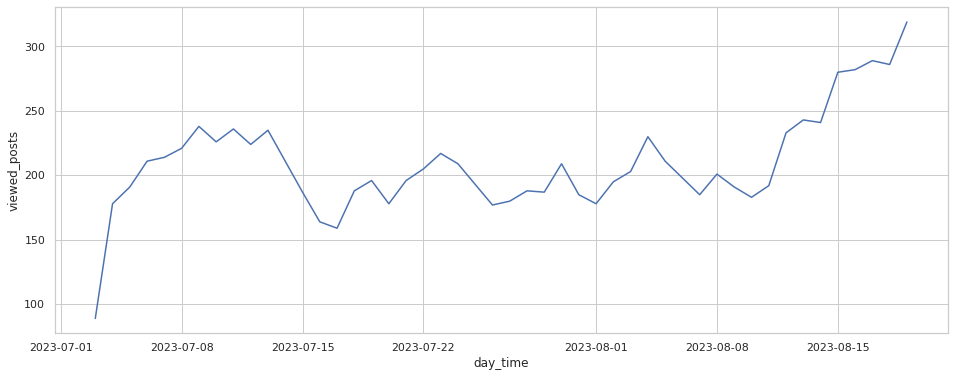

In [71]:
sns.lineplot(data=uniq_posts, x="day_time", y="viewed_posts")

In [31]:
# строим модель
uniq_ci = CausalImpact(data=uniq_posts.set_index("day_time"), 
             pre_period=[pd.Timestamp("2023-07-03"), 
                         pd.Timestamp("2023-08-12")],
             post_period=[pd.Timestamp("2023-08-13"), 
                         pd.Timestamp("2023-08-19")])

2023-09-12 19:54:10.993316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-12 19:54:11.015695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-09-12 19:54:11.661912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-12 19:

2023-09-12 19:54:33.007975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-09-12 19:54:33.092749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

In [32]:
print(uniq_ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    277.14             1940.0
Prediction (s.d.)         197.33 (9.46)      1381.29 (66.2)
95% CI                    [179.16, 216.23]   [1254.1, 1513.58]

Absolute effect (s.d.)    79.82 (9.46)       558.71 (66.2)
95% CI                    [60.92, 97.99]     [426.42, 685.9]

Relative effect (s.d.)    40.45% (4.79%)     40.45% (4.79%)
95% CI                    [30.87%, 49.66%]   [30.87%, 49.66%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


Есть прирост количества уникальных просматриваемых постов примерно на 80%  относительного предсказанного моделью, казуальный эффект есть.

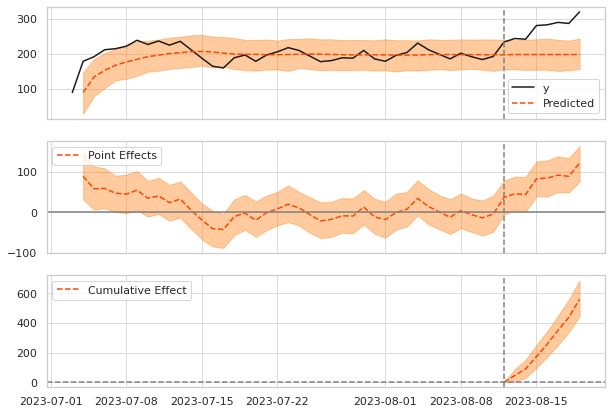

In [33]:
uniq_ci.plot()

## Новые посты

In [34]:
query_new_post = '''
SELECT 
    first_post as day_time,
    count(post_id) as posts
FROM
    (SELECT 
        min(day_time) first_post,
        post_id
    FROM
        (SELECT 
          toStartOfDay(time) day_time,
          post_id
        FROM
          {db}.feed_actions
        WHERE
          toDate(time) <= '2023-08-19'
        )
    GROUP BY post_id)
GROUP BY day_time
ORDER BY day_time
'''

new_posts = ph.read_clickhouse(query = query_new_post, connection = connection)

In [35]:
new_posts.head()

,day_time,posts
0,2023-07-03,89
1,2023-07-04,97
2,2023-07-05,61
3,2023-07-06,87
4,2023-07-07,70


<Axes: xlabel='day_time', ylabel='posts'>

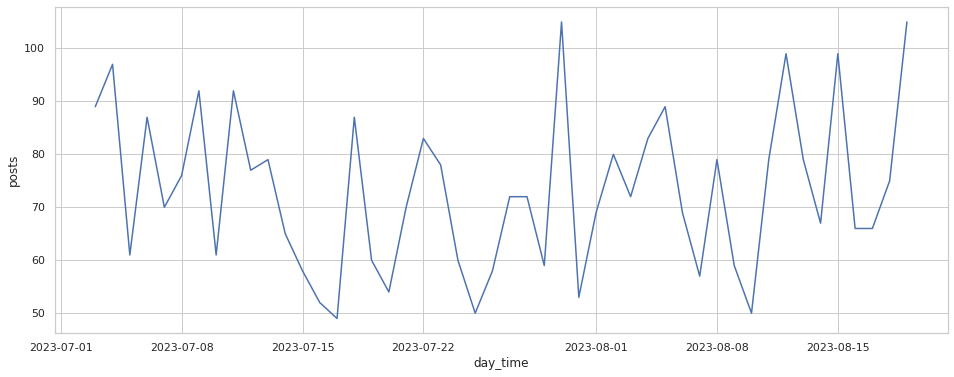

In [72]:
sns.lineplot(data=new_posts, x="day_time", y="posts")

In [37]:
new_ci = CausalImpact(data=new_posts.set_index("day_time"), 
             pre_period=[pd.Timestamp("2023-07-03"), 
                         pd.Timestamp("2023-08-12")],
             post_period=[pd.Timestamp("2023-08-13"), 
                         pd.Timestamp("2023-08-19")])

2023-09-12 19:54:36.233622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-12 19:54:36.260417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2023-09-12 19:54:36.836634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2023-09-12 19:

2023-09-12 19:54:55.960657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-09-12 19:54:56.069690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

In [38]:
print(new_ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    79.57              557.0
Prediction (s.d.)         72.03 (5.08)       504.21 (35.58)
95% CI                    [61.93, 81.85]     [433.48, 572.97]

Absolute effect (s.d.)    7.54 (5.08)        52.79 (35.58)
95% CI                    [-2.28, 17.65]     [-15.97, 123.52]

Relative effect (s.d.)    10.47% (7.06%)     10.47% (7.06%)
95% CI                    [-3.17%, 24.5%]    [-3.17%, 24.5%]

Posterior tail-area probability p: 0.07
Posterior prob. of a causal effect: 93.21%

For more details run the command: print(impact.summary('report'))


Возможно какой-то минимальный прирост количества новых постов и есть, но доверительные интервалы абсолютного и относительного эффектов пересекают ноль. Будем считать, что казуального эффекта нет. А так как ранее мы выяснили, что есть существенный прирост количества уникальных просматриваемых постов в день, то можно сделать вывод что выросло общее время жизни постов.

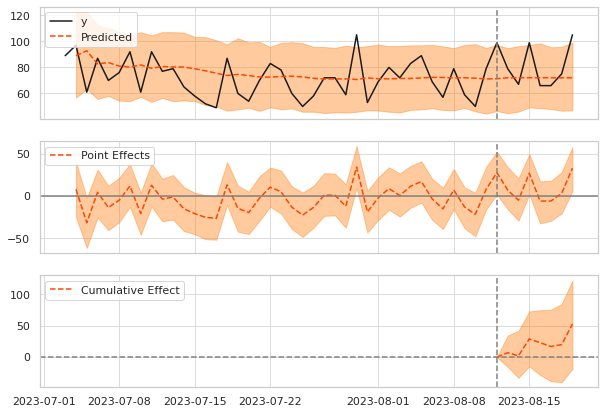

In [39]:
new_ci.plot()

# Улучшение моделей

Как можно было заметить по графикам лайков, просмотров и DAU, текущая модель не очень хорошо описывает наши данные до проведения флэшмоба - систематически средние предсказанные значения ниже, чем реальные. Связано это с тем, что модель по умолчанию не учитывает наличие тренда, а в наших данных он есть.

### Добавление тренда

Помимо [документации TFP](https://www.tensorflow.org/probability/api_docs/python/tfp/sts), будем ориентироваться на настройки [Causal Impact](https://github.com/WillianFuks/tfcausalimpact/blob/master/causalimpact/model.py).

Для примера сделаем это на данных по просмотрам:

In [40]:
#тренд

#причёсываем
data = activity.drop("day_time", axis=1).astype(np.float32)

#стандартизуем
normed_data, _ = causalimpact.misc.standardize(data)

obs_data = normed_data.iloc[:41, 1]

trend_component = tfp.sts.LocalLinearTrend(observed_time_series=obs_data)

In [41]:
# строим модель по просмотрам с учетом тренда
views_custom = CausalImpact(data=activity.set_index("day_time").views, 
                            pre_period=[pd.Timestamp("2023-07-03"), 
                                        pd.Timestamp("2023-08-12")],
                            post_period=[pd.Timestamp("2023-08-13"), 
                                         pd.Timestamp("2023-08-19")],
                            model=trend_component)

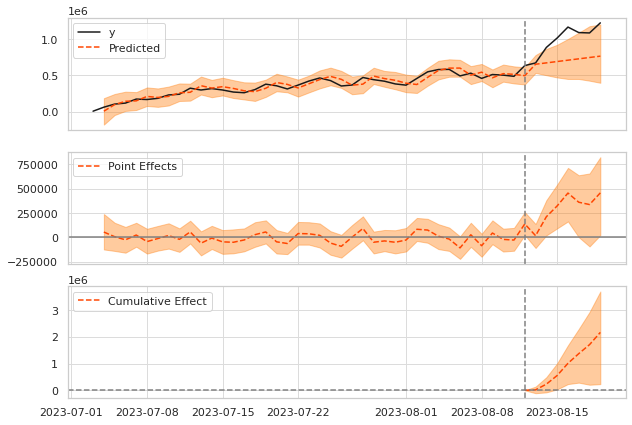

In [42]:
# рисуем график
views_custom.plot()

Теперь модель более точно описывает наши данные до флэшмоба

In [43]:
print(views_custom.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1019947.31         7139631.0
Prediction (s.d.)         710118.0 (124455.47)4970826.0 (871188.26)
95% CI                    [474944.76, 962801.35][3324613.34, 6739609.3]

Absolute effect (s.d.)    309829.31 (124455.47)2168805.0 (871188.26)
95% CI                    [57145.96, 545002.55][400021.7, 3815017.66]

Relative effect (s.d.)    43.63% (17.53%)    43.63% (17.53%)
95% CI                    [8.05%, 76.75%]    [8.05%, 76.75%]

Posterior tail-area probability p: 0.02
Posterior prob. of a causal effect: 98.2%

For more details run the command: print(impact.summary('report'))


То же самое с лайками:

In [44]:
# строим модель по просмотрам с учетом тренда
likes_custom = CausalImpact(data=activity.set_index("day_time").likes, 
                            pre_period=[pd.Timestamp("2023-07-03"), 
                                        pd.Timestamp("2023-08-12")],
                            post_period=[pd.Timestamp("2023-08-13"), 
                                         pd.Timestamp("2023-08-19")],
                            model=trend_component)

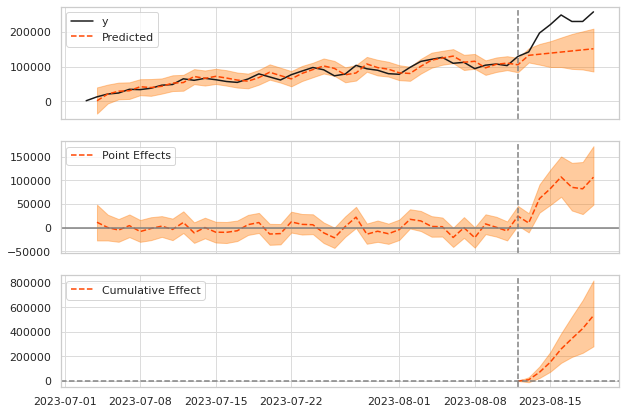

In [45]:
likes_custom.plot()

Так же видим что модель описывает данные более точно

In [46]:
print(likes_custom.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    218090.14          1526631.0
Prediction (s.d.)         141928.73 (19197.58)993501.12 (134383.07)
95% CI                    [103718.2, 178971.34][726027.38, 1252799.43]

Absolute effect (s.d.)    76161.41 (19197.58)533129.88 (134383.07)
95% CI                    [39118.8, 114371.95][273831.57, 800603.62]

Relative effect (s.d.)    53.66% (13.53%)    53.66% (13.53%)
95% CI                    [27.56%, 80.58%]   [27.56%, 80.58%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.9%

For more details run the command: print(impact.summary('report'))


Да и DAU тоже:

In [47]:
#тренд

#причёсываем
data = dau.drop("day_time", axis=1).astype(np.float32)

#стандартизуем
normed_data, _ = causalimpact.misc.standardize(data)

#берем интервал до проведения флэшмоба
obs_data = normed_data.iloc[:41, 0]

#в TFP есть такая штука как локальный линейный тренд, скармливаем ей наши данные
trend_component_dau = tfp.sts.LocalLinearTrend(observed_time_series=obs_data)

In [48]:
dau_custom = CausalImpact(data=dau.set_index("day_time"), 
                            pre_period=[pd.Timestamp("2023-07-03"), 
                                        pd.Timestamp("2023-08-12")],
                            post_period=[pd.Timestamp("2023-08-13"), 
                                         pd.Timestamp("2023-08-19")],
                            model=trend_component_dau)

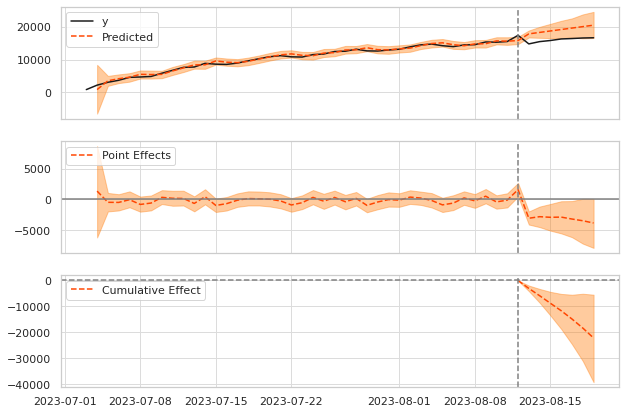

In [49]:
dau_custom.plot()

In [50]:
print(dau_custom.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    16052.71           112369.0
Prediction (s.d.)         19221.03 (1100.75) 134547.22 (7705.28)
95% CI                    [17145.05, 21459.93][120015.35, 150219.52]

Absolute effect (s.d.)    -3168.32 (1100.75) -22178.22 (7705.28)
95% CI                    [-5407.22, -1092.34][-37850.52, -7646.35]

Relative effect (s.d.)    -16.48% (5.73%)    -16.48% (5.73%)
95% CI                    [-28.13%, -5.68%]  [-28.13%, -5.68%]

Posterior tail-area probability p: 0.01
Posterior prob. of a causal effect: 99.4%

For more details run the command: print(impact.summary('report'))


Обратите внимание, что аномальное событие сдвинуло эффект! Предсказание оказывается выше чем реальный показатель. Стоит это тоже учесть:

In [51]:
#посчитаем среднее значение между днём до и днём после
#и на него заменим аномалию

dau.loc[dau.day_time == '2023-08-12', "DAU"] = dau.query("day_time == '2023-08-11' or day_time == '2023-08-13'").DAU.mean()

In [52]:
#тренд

#причёсываем
data = dau.drop("day_time", axis=1).astype(np.float32)

#стандартизуем
normed_data, _ = causalimpact.misc.standardize(data)

#берем интервал до флэшмоба
obs_data = normed_data.iloc[:41, 0]

trend_component_dau = tfp.sts.LocalLinearTrend(observed_time_series=obs_data)

In [53]:
dau_custom = CausalImpact(data=dau.set_index("day_time"), 
                            pre_period=[pd.Timestamp("2023-07-03"), 
                                        pd.Timestamp("2023-08-12")],
                            post_period=[pd.Timestamp("2023-08-13"), 
                                         pd.Timestamp("2023-08-19")],
                            model=trend_component_dau)

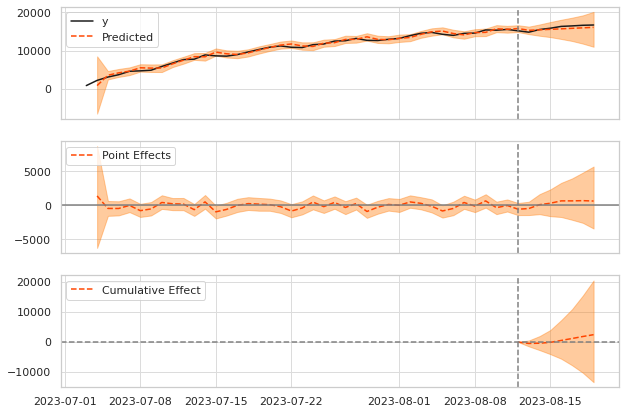

In [54]:
dau_custom.plot()

После исключения из данных аномалии все наши данные хорошо описываются прогнозом. Так же можно сделать вывод, что метрика DAU в результате проведения флэшмоба не выросла.

In [55]:
print(dau_custom.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    16052.71           112369.0
Prediction (s.d.)         15705.62 (1189.4)  109939.38 (8325.79)
95% CI                    [13185.63, 17847.99][92299.41, 124935.9]

Absolute effect (s.d.)    347.09 (1189.4)    2429.62 (8325.79)
95% CI                    [-1795.27, 2867.08][-12566.9, 20069.59]

Relative effect (s.d.)    2.21% (7.57%)      2.21% (7.57%)
95% CI                    [-11.43%, 18.26%]  [-11.43%, 18.26%]

Posterior tail-area probability p: 0.38
Posterior prob. of a causal effect: 61.64%

For more details run the command: print(impact.summary('report'))


Выводы сделаные по графику так же подтверждаются цифрами в summary

### Изолировать каузальный эффект

Еще можно попробовать оценить насколько выросли просмотры и лайки относительно прироста в уникальных просматриваемых постах. Проверить это попытаемся изолировав казуальный эффект. Смоделируем ситуацию когда выросли только посты, но не изменились просмотры и лайки. Если даже с учетом этого модель будет делать вывод, что лайки и просмотры выросли, то можно будет сказать что они выросли и сами по себе, а не только из-за того что изменилось количество просматриваемых постов.

In [56]:
causality = activity.drop(["likes", "CTR"], axis=1)

In [57]:
causality.insert(2, "uniq_posts", uniq_posts.viewed_posts)

In [58]:
causality.head()

,day_time,views,uniq_posts
0,2023-07-03,7603,89
1,2023-07-04,62770,178
2,2023-07-05,105526,191
3,2023-07-06,118996,211
4,2023-07-07,174454,214


In [59]:
#причёсываем
data = causality.drop("day_time", axis=1).astype(np.float32)

#стандартизуем
normed_data, _ = causalimpact.misc.standardize(data)

#берем интервал до флэшмоба
obs_data = normed_data.iloc[:41, 0]

trend_component = tfp.sts.LocalLinearTrend(observed_time_series=obs_data)

In [60]:
#изменяем форму на необходимую
normed_data.iloc[:, 1].values.reshape(-1, 1).shape

(48, 1)

In [61]:
#добавим элемент регрессии

linear_reg = tfp.sts.LinearRegression(design_matrix=normed_data.iloc[:, 1].values.reshape(-1, 1).astype(np.float32))

In [62]:
#объединяем компоненты модели

custom_model = tfp.sts.Sum([trend_component, linear_reg], observed_time_series=obs_data)

In [63]:
#строим модель по просмотрам с учетом тренда и регрессии
reg_custom = CausalImpact(data=causality.set_index("day_time"), 
                            pre_period=[pd.Timestamp("2023-07-03"), 
                                        pd.Timestamp("2023-08-12")],
                            post_period=[pd.Timestamp("2023-08-13"), 
                                         pd.Timestamp("2023-08-19")],
                            model=custom_model)

2023-09-12 19:56:15.333818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-09-12 19:56:15.333975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-09-12 19:56:15.346836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2023-09-12 19:56:15.347047: I tens

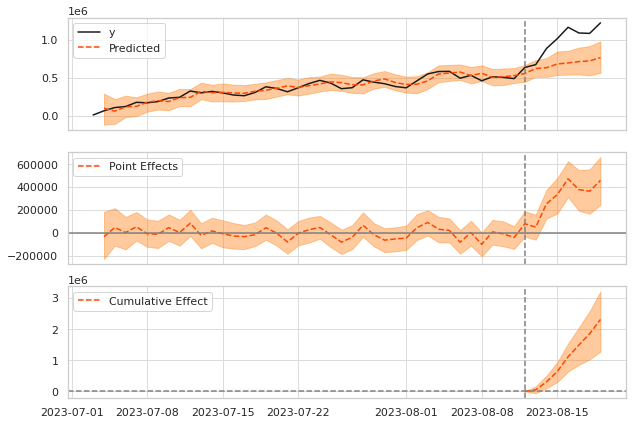

In [64]:
reg_custom.plot()

Можно сделать вывод что просморы выросли независимо от количества уникальных просматриваемых постов. Вероятно аналогичная ситуация и по лайкам.

In [65]:
print(reg_custom.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1019947.31         7139631.0
Prediction (s.d.)         689937.12 (66564.61)4829560.0 (465952.27)
95% CI                    [566901.65, 827830.18][3968311.38, 5794811.1]

Absolute effect (s.d.)    330010.19 (66564.61)2310071.0 (465952.27)
95% CI                    [192117.13, 453045.66][1344819.9, 3171319.62]

Relative effect (s.d.)    47.83% (9.65%)     47.83% (9.65%)
95% CI                    [27.85%, 65.66%]   [27.85%, 65.66%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


# Выводы

С одной стороны, судя по приросту просмотров, лайков и уникальных просматриваемых постов, пользователи не проигнорировали наш флэшмоб. То есть активность удалось возбудить и с этой точки зрения он достиг своей цели. Но при этом DAU не изменился, то есть новых пользователей флэшмоб не захватил, актвность выросла только у тех пользователей, которые судя по всему и так были вовлечены в наш продукт. И с этой точки зрения флэшмоб оказался неэффективным.